## Datalake and Data Sources

In general, it is important to have a good understanding of the inputs and outputs of a process. This is crucial when you want to distribute the execution of a process.

During the creation phase, a data scientist will generally rely on a datalake: relatively raw data that they will seek to exploit. This datalake typically takes the form of a distributed file system.

Spark relies on Hadoop libraries to load data from the datalake into memory. Most datalakes use HDFS (Hadoop Distributed File System) technology. However, this is not the choice we made for the datalab.

#### Choosing an S3-based Datalake

This tutorial focuses on connecting Spark to a data source in the broad sense of the term. Other sources are possible (RDBMS, NoSQL databases). In particular, we focus on object-oriented storage with the S3 API. Why choose S3 storage over HDFS, Hadoop's distributed storage system? HDFS emerged with the need to **co-locate processing and data** in the Big Data world. This was a strong concept promoted by MapReduce following Google's work in 2004.
To be brief, this model is declining because it's too expensive to maintain and it increasingly doesn't match our data processing workflows. Today, many projects involve machine learning methods, which require costly CPU/GPU (or even TPU) resources for training models, but usually on relatively small datasets. The new trend is to decouple the growth of storage capacity from processing capacity. S3 storage, which is an API for object distribution (file + associated metadata), is growing rapidly, benefiting from the support of public cloud providers and its intrinsic qualities:
* An HTTP API, making it easily accessible
* Compatible with Hadoop as a data source
* Encryption and authentication functions on demand

In short, this is the model we highlight in the datalab for its ease of implementation, ease of securing and auditing, and lower cost, with the risk of losing a bit of speed due to the non-co-location of processing and data.

### Let's go

No changes, we start our local Spark context... we'll see later about distributing computations in a cluster.

In [3]:
from pyspark.sql import SparkSession

spark = (SparkSession 
         .builder
         .appName("Datalake TP")
         .master("local[5]")
         .getOrCreate()
        )

### The Data: Sirene Open Data

I have placed open data from the Sirene database into a project bucket (projet-spark-lab) in the **diffusion folder, which is accessible for viewing to anyone with an account in the datalab. This is true for all buckets, including all of yours.**

It is important to note that our Datalake has all the characteristics of a DataSwamp: without governance and without a search engine, it's a real data swamp where data duplications will be rampant.


In [4]:
!mc ls s3/projet-spark-lab/diffusion/formation/data/sirene/sirene.csv

]11;?\[2022-02-10 21:50:17 UTC] 6.5GiB STANDARD sirene.csv


### Loading Data and SparkSQL

In the introduction, we used only RDDs: [https://spark.apache.org/docs/latest/rdd-programming-guide.html](https://spark.apache.org/docs/latest/rdd-programming-guide.html)
This is a low-level programming interface that offers great development freedom on unstructured files. However, in practice, we most often have structured data, particularly in table form. Therefore, the model of Spark DataFrames and the SparkSQL programming interface allows for simpler manipulation, with optimizations derived from relational algebra theories.

In the introduction, we also downloaded the file locally before referencing it in Spark. **Here we will directly reference the file that is on remote storage.**
Moreover, we will load the CSV file using the following method, inferring the schema.

**Spark will then need to read the entire file to deduce the type of each column in the file.**


In [5]:
df = (spark
      .read.format("csv")
      .options(header='true', inferschema='true', delimiter=',')
      .load("s3a://projet-spark-lab/diffusion/formation/data/sirene/sirene.csv")
     )

In [6]:
df.printSchema()

root
 |-- siren: integer (nullable = true)
 |-- nic: integer (nullable = true)
 |-- siret: long (nullable = true)
 |-- dateFin: date (nullable = true)
 |-- dateDebut: date (nullable = true)
 |-- etatAdministratifEtablissement: string (nullable = true)
 |-- changementEtatAdministratifEtablissement: boolean (nullable = true)
 |-- enseigne1Etablissement: string (nullable = true)
 |-- enseigne2Etablissement: string (nullable = true)
 |-- enseigne3Etablissement: string (nullable = true)
 |-- changementEnseigneEtablissement: boolean (nullable = true)
 |-- denominationUsuelleEtablissement: string (nullable = true)
 |-- changementDenominationUsuelleEtablissement: boolean (nullable = true)
 |-- activitePrincipaleEtablissement: string (nullable = true)
 |-- nomenclatureActivitePrincipaleEtablissement: string (nullable = true)
 |-- changementActivitePrincipaleEtablissement: string (nullable = true)
 |-- caractereEmployeurEtablissement: string (nullable = true)
 |-- changementCaractereEmployeurEta

In [7]:
df

DataFrame[siren: int, nic: int, siret: bigint, dateFin: date, dateDebut: date, etatAdministratifEtablissement: string, changementEtatAdministratifEtablissement: boolean, enseigne1Etablissement: string, enseigne2Etablissement: string, enseigne3Etablissement: string, changementEnseigneEtablissement: boolean, denominationUsuelleEtablissement: string, changementDenominationUsuelleEtablissement: boolean, activitePrincipaleEtablissement: string, nomenclatureActivitePrincipaleEtablissement: string, changementActivitePrincipaleEtablissement: string, caractereEmployeurEtablissement: string, changementCaractereEmployeurEtablissement: string]

In [9]:
# With dataframe api
df.select("siren", "siret").show(5)

+------+-----------+
| siren|      siret|
+------+-----------+
|325175|32517500016|
|325175|32517500016|
|325175|32517500016|
|325175|32517500024|
|325175|32517500024|
+------+-----------+
only showing top 5 rows



In [10]:
# With SQL query
df.createOrReplaceTempView("sirene")

sqlDF = spark.sql("SELECT siren, siret FROM sirene LIMIT 5")
sqlDF.show()

print(sqlDF.count())

+------+-----------+
| siren|      siret|
+------+-----------+
|325175|32517500016|
|325175|32517500016|
|325175|32517500016|
|325175|32517500024|
|325175|32517500024|
+------+-----------+



5


### Schema for data access

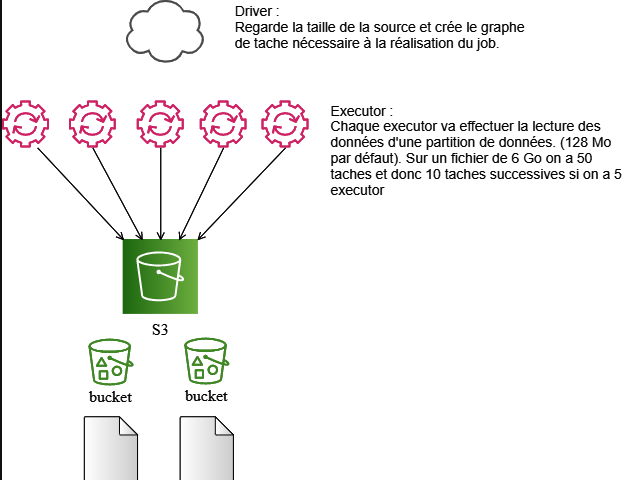


## Conclusion

Within the datalab, accessing your personal data space from Spark is directly supported by the infrastructure. The effort is minimal since you only need to specify the file URL preceded by the s3a protocol: `s3a://bucket/path/to/file`.

Having a distributed file system is a prerequisite for starting to distribute your computation across a machine cluster.

Note that the CSV format is far from being the recommended format for large data volumes.

In [11]:
spark.stop()